In [2]:
import pandas as pd
from scipy import signal
import random

# 读取微表情标注文件

In [3]:
file_path = 'coding_file_combined.xlsx'
df_xlsx = pd.read_excel(file_path)
df_xlsx.head(3)

,Subject,Filename,Marker,OnsetTime,ApexTime,OffsetTime,OnsetFrame,ApexFrame,OffsetFrame,Action Units,Estimated Emotion,Macro/Micro,Date,dif
0,fengdengfang,angry_1_146_fengdengfang_20230802.avi,146,24.33,24.59,25.33,16-00-31-433-685,16-00-31-686-723,16-00-32-428-831,AU1,angry,Macro,2024年06月30日-14时31分,39
1,wangxiaomin,angry_1_146_wangxiaomin_20230718.avi,146,12.09,12.68,12.68,11-05-27-805-813,11-05-28-399-902,11-05-28-399-902,AU4,angry,Macro,2024年05月15日-19时52分,90
2,wangxiaomin,angry_1_146_wangxiaomin_20230718.avi,146,3.32,3.60,3.60,11-05-19-038-498,11-05-19-318-540,11-05-19-318-540,AU4,angry,Macro,2024年05月15日-20时55分,43


## 获取微表情峰值帧字典

In [4]:
df_micro = df_xlsx[df_xlsx['Macro/Micro']=='Micro']

# 初始化一个空的字典来存储键值对
subject_apextime_micro_dict = {}

# 遍历DataFrame的每一行
for index, row in df_micro.iterrows():
    key = row['Filename'].split('.')[0]
    value = row['ApexTime']
    
    # 如果Subject已经在字典中，将ApexTime添加到对应的列表
    if key in subject_apextime_micro_dict:
        subject_apextime_micro_dict[key].append(value)
        # 对列表进行排序以确保它是升序的
        subject_apextime_micro_dict[key] = sorted(subject_apextime_micro_dict[key])
    else:
        # 如果Subject不在字典中，创建一个新的列表并添加ApexTime
        subject_apextime_micro_dict[key] = [value]

# 打印结果字典
for key, value in subject_apextime_micro_dict.items():
    print(f"{key}: {value}")

angry_1_146_yangmi_20230728: [8.51, 11.6, 26.38, 27.9, 28.6, 41.1, 41.18]
angry_2_107_wangshuai_20230802: [28.5, 29.84]
angry_2_107_wangzishan_20230717: [26.26]
angry_2_107_zhaoshaohua_20230801: [17.11, 17.19, 25.15]
angry_3_116_liyan_20230802: [1.97, 10.25, 41.57]
angry_3_116_yangmi_20230728: [5.21, 5.22, 8.61, 21.45, 31.54, 34.42, 34.42, 51.69, 51.71]
angry_3_116_zhaoshaohua_20230801: [25.62, 25.64]
angry_4_125_wangziheng_20230727: [53.96]
angry_4_125_zhengwansheng_20230718: [6.54]
angry_5_133_wangxiaomin_20230718: [2.47, 2.55, 6.75]
angry_6_142_wangxiaomin_20230718: [3.73]
disgust_1_112_zhaoshaohua_20230801: [13.34, 13.38, 18.33, 21.1, 22.0, 34.75, 35.47, 35.48, 49.39]
disgust_1_112_zhengwansheng_20230718: [49.1, 54.05]
disgust_2_102_wangxiaomin_20230718: [53.15]
disgust_2_102_yangmi_20230728: [2.18, 2.21, 3.17, 3.57, 10.28]
disgust_2_102_zhangbuyuan_20230801: [52.1, 54.75]
disgust_2_102_zhaoshaohua_20230801: [3.0, 5.22, 5.22, 7.23]
disgust_3_110_wangxiaomin_20230718: [15.57, 26.5, 

# read Neuroscan

In [5]:
import os
import numpy as np
import mne
from mne.io import read_raw_eeglab
from scipy.io import savemat, loadmat
import h5py
import neurokit2 as nk
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import warnings
from scipy.io import savemat
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning)

## 加载要分析的被试数据

In [6]:
eeg_path = 'eeg_py\eeg_for_mne'

for dirpath, dirnames, filenames in os.walk(eeg_path):
    filenames_set = [s for s in filenames if '.set' in s]
    print('filenames_set:', filenames_set)
    print('len(filenames_set):', len(filenames_set))

filenames_set: ['fengdengfang_20230802.set', 'linjiaying_20230719.set', 'liyan_20230802.set', 'lizhuoru_20230720.set', 'lvpinxin_20230803.set', 'mayiran_20230718.set', 'wangjintao_20230719.set', 'wangshuai_20230802.set', 'wangsixian_20230719.set', 'wangxiaomin_20230718.set', 'wangziheng_20230727.set', 'wangzishan_20230717.set', 'xietao_20230803.set', 'yangmi_20230728.set', 'yansen_20230731.set', 'yuelu_20230720.set', 'zhangbuyuan_20230801.set', 'zhangdi_20230721.set', 'zhaolei_20230803.set', 'zhaoshaohua_20230801.set', 'zhengwansheng_20230718.set']
len(filenames_set): 21


每个文件时长约为1小时，行数约为：60×60×1000=3600000

In [41]:
selected_subject = 'fengdengfang_20230802'
selected_file = selected_subject + '.set'
selected_file

'fengdengfang_20230802.set'

In [42]:
raw = mne.io.read_raw_eeglab(os.path.join(eeg_path, selected_file), 
    eog=(), 
    preload=False, 
    uint16_codec=None, 
    montage_units='auto', 
    verbose=None
)

print('raw.annotations:', raw.annotations)
print('')
print('raw.annotations.description):', list(raw.annotations.description))

Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\fengdengfang_20230802.fdt
raw.annotations: <Annotations | 98 segments: 100 (48), 101 (1), 102 (1), 103 (1), 104 (1), ...>

raw.annotations.description): ['77', '88', '101', '100', '102', '100', '103', '100', '104', '100', '105', '100', '106', '100', '107', '100', '108', '100', '109', '100', '110', '100', '111', '100', '112', '100', '113', '100', '114', '100', '115', '100', '116', '100', '117', '100', '118', '100', '119', '100', '120', '100', '121', '100', '122', '100', '123', '100', '124', '100', '125', '100', '126', '100', '127', '100', '128', '100', '129', '100', '130', '100', '131', '100', '132', '100', '133', '100', '134', '100', '135', '100', '136', '100', '137', '100', '138', '100', '139', '100', '140', '100', '141', '100', '142', '100', '143', '100', '144', '100', '145', '100', '146', '100', '147', '100', '148', '100']


## 数据预处理

### 删除异常值
- 原始数据的marker会产生无效标签，如77、88，需要过滤掉

In [43]:
markers_all = list(raw.annotations.description)
markers_retain = [str(marker) for marker in list(range(99, 149))] # 100~148
markers_del = list(set([item for item in markers_all if item not in markers_retain]))
print('markers_del:', markers_del)

print('raw.annotations.description:', raw.annotations.description)

to_remove = []
for m in markers_del:
    to_remove.append(list(raw.annotations.description).index(m))
    raw.annotations.delete(to_remove[-1])

print('to_remove:', to_remove)
    
print('raw.annotations:', raw.annotations)
print('raw.annotations.description:', raw.annotations.description)

markers_del: ['88', '77']
raw.annotations.description: ['77' '88' '101' '100' '102' '100' '103' '100' '104' '100' '105' '100'
 '106' '100' '107' '100' '108' '100' '109' '100' '110' '100' '111' '100'
 '112' '100' '113' '100' '114' '100' '115' '100' '116' '100' '117' '100'
 '118' '100' '119' '100' '120' '100' '121' '100' '122' '100' '123' '100'
 '124' '100' '125' '100' '126' '100' '127' '100' '128' '100' '129' '100'
 '130' '100' '131' '100' '132' '100' '133' '100' '134' '100' '135' '100'
 '136' '100' '137' '100' '138' '100' '139' '100' '140' '100' '141' '100'
 '142' '100' '143' '100' '144' '100' '145' '100' '146' '100' '147' '100'
 '148' '100']
to_remove: [1, 0]
raw.annotations: <Annotations | 96 segments: 100 (48), 101 (1), 102 (1), 103 (1), 104 (1), ...>
raw.annotations.description: ['101' '100' '102' '100' '103' '100' '104' '100' '105' '100' '106' '100'
 '107' '100' '108' '100' '109' '100' '110' '100' '111' '100' '112' '100'
 '113' '100' '114' '100' '115' '100' '116' '100' '117' '100'

## 获取marker、label、emotion

In [44]:
raw.annotations.onset

array([  72.787,  131.812,  172.009,  229.868,  274.653,  327.28 ,
        359.531,  415.385,  466.211,  523.006,  583.335,  632.762,
        664.963,  707.622,  743.043,  801.366,  832.122,  877.244,
        910.627,  964.248, 1024.563, 1077.791, 1119.051, 1174.919,
       1198.303, 1252.466, 1277.884, 1323.874, 1356.932, 1411.896,
       1450.115, 1508.441, 1534.267, 1593.394, 1619.468, 1662.266,
       1698.513, 1754.241, 1785.642, 1844.398, 1880.925, 1933.62 ,
       1961.944, 2018.906, 2065.348, 2115.885, 2150.107, 2207.043,
       2246.518, 2302.654, 2349.378, 2393.545, 2416.895, 2474.561,
       2522.953, 2579.446, 2607.989, 2661.913, 2704.44 , 2761.144,
       2789.92 , 2846.214, 2875.039, 2927.729, 2967.403, 3026.493,
       3060.068, 3112.363, 3143.736, 3202.47 , 3245.121, 3304.586,
       3341.784, 3396.644, 3456.951, 3516.142, 3553.937, 3608.5  ,
       3643.942, 3699.641, 3723.394, 3770.916, 3804.944, 3861.84 ,
       3897.708, 3951.596, 3972.603, 4030.527, 4059.811, 4112.

In [45]:
time_marker_dict = dict(zip(list(raw.annotations.onset), list(raw.annotations.description)))
time_marker_dict

{72.787: '101',
 131.812: '100',
 172.009: '102',
 229.868: '100',
 274.653: '103',
 327.28: '100',
 359.531: '104',
 415.385: '100',
 466.211: '105',
 523.006: '100',
 583.335: '106',
 632.762: '100',
 664.963: '107',
 707.622: '100',
 743.043: '108',
 801.366: '100',
 832.122: '109',
 877.244: '100',
 910.627: '110',
 964.248: '100',
 1024.563: '111',
 1077.791: '100',
 1119.051: '112',
 1174.919: '100',
 1198.303: '113',
 1252.466: '100',
 1277.884: '114',
 1323.874: '100',
 1356.932: '115',
 1411.896: '100',
 1450.115: '116',
 1508.441: '100',
 1534.267: '117',
 1593.394: '100',
 1619.468: '118',
 1662.266: '100',
 1698.513: '119',
 1754.241: '100',
 1785.642: '120',
 1844.398: '100',
 1880.925: '121',
 1933.62: '100',
 1961.944: '122',
 2018.906: '100',
 2065.348: '123',
 2115.885: '100',
 2150.107: '124',
 2207.043: '100',
 2246.518: '125',
 2302.654: '100',
 2349.378: '126',
 2393.545: '100',
 2416.895: '127',
 2474.561: '100',
 2522.953: '128',
 2579.446: '100',
 2607.989: '129

In [46]:
df_raw = raw.to_data_frame()
df_raw.shape

(4402200, 69)

In [47]:
def assign_marker(time, time_marker_dict):
    # 获取 time_marker_dict 的 keys，并进行排序
    sorted_keys = sorted(time_marker_dict.keys())
    
    # 如果 time 小于所有的 key，返回 '100'
    if time < sorted_keys[0]:
        return '100'
    
    # 遍历 sorted_keys，找到 time 所在的区间
    for i in range(len(sorted_keys) - 1):
        if sorted_keys[i] <= time < sorted_keys[i + 1]:
            return time_marker_dict[sorted_keys[i]]
    
    # 如果 time 大于最后一个键的值，返回最后一个键对应的 value
    if time >= sorted_keys[-1]:
        return time_marker_dict[sorted_keys[-1]]
    
    return None

In [48]:
df_raw['marker'] = df_raw['time'].apply(lambda x: assign_marker(x, time_marker_dict))

In [49]:
df_raw.head()

,time,FP1,FPZ,FP2,AF3,AF4,F7,F5,F3,F1,...,CB1,O1,OZ,O2,CB2,HEO,VEO,EKG,EMG,marker
0,0.000,-20.573795,-65.021858,-12.615759,-11.734818,-22.098469,-11.075542,3.098398,-29.395409,-20.254015,...,48.351940,31.999506,24.326208,100.206940,46.288788,-92.562759,39.734264,-117.223351,-278.969330,100
1,0.001,-19.768562,-62.865662,-11.352083,-8.850757,-21.780554,-11.468485,4.612144,-27.813393,-19.147079,...,50.254257,33.781185,21.050146,90.189278,49.211575,-94.784645,39.116322,-112.158684,-219.964249,100
2,0.002,-20.264772,-63.195396,-11.446539,-6.734233,-22.029150,-15.892743,12.192110,-24.058764,-16.938055,...,51.935123,37.463692,25.281454,95.872017,52.384369,-96.675278,38.776707,-92.405327,-162.685883,100
3,0.003,-19.026922,-59.354393,-10.076377,-3.859205,-20.235567,-26.732752,19.848932,-19.528667,-13.934881,...,44.029369,32.905685,22.783703,93.144875,37.161251,-97.297379,38.338921,-65.733063,-109.939964,100
4,0.004,-16.873671,-57.726845,-9.777512,-3.023626,-19.745031,-37.965546,23.067003,-16.472864,-12.053852,...,35.366772,26.236935,16.199257,86.751114,20.673672,-96.759102,38.993130,-25.204615,-69.270409,100


In [50]:
df_copy = df_raw

In [51]:
marker2label = {100: 0, 101: 1, 102: 2, 103: 3, 104: 4, 105: 5, 106: 6, 107: 7, 108: 8, 109: 1, 110: 2, 111: 3, 112: 2, 113: 4, 114: 5, 115: 6, 116: 7, 117: 8, 118: 1, 119: 2, 120: 3, 121: 4, 122: 5, 123: 3, 124: 6, 125: 7, 126: 8, 127: 1, 128: 2, 129: 3, 130: 4, 131: 5, 132: 6, 133: 7, 134: 4, 135: 8, 136: 1, 137: 2, 138: 3, 139: 4, 140: 5, 141: 6, 142: 7, 143: 8, 144: 5, 145: 6, 146: 7, 147: 8, 148: 1}
label2emotion = {0: 'useless', 1: 'sad', 2: 'disgust', 3: 'happy', 4: 'fear', 5: 'nervous', 6: 'calm', 7: 'anger', 8: 'surprise'}

# 定义一个函数，根据 marker 值查找对应的 label
def marker_to_label(marker):
    return marker2label.get(int(marker), None)  # 使用 get 方法，如果找不到对应的 marker，返回 None

# 定义一个函数，根据 label 值查找对应的 emotion
def label_to_emotion(label):
    return label2emotion.get(label, None)  # 使用 get 方法，如果找不到对应的 label，返回 None

# 使用 apply 函数将 marker_to_label 应用于 df_raw 的 'marker' 列，生成新的 'label' 列
df_copy['label'] = df_copy['marker'].apply(marker_to_label)
df_raw['label'] = df_raw['label'].astype(int)

# 使用 apply 函数将 label_to_emotion 应用于 df_raw 的 'label' 列，生成新的 'emotion' 列
df_copy['emotion'] = df_copy['label'].apply(label_to_emotion)

In [52]:
df_copy.head()

,time,FP1,FPZ,FP2,AF3,AF4,F7,F5,F3,F1,...,OZ,O2,CB2,HEO,VEO,EKG,EMG,marker,label,emotion
0,0.000,-20.573795,-65.021858,-12.615759,-11.734818,-22.098469,-11.075542,3.098398,-29.395409,-20.254015,...,24.326208,100.206940,46.288788,-92.562759,39.734264,-117.223351,-278.969330,100,0,useless
1,0.001,-19.768562,-62.865662,-11.352083,-8.850757,-21.780554,-11.468485,4.612144,-27.813393,-19.147079,...,21.050146,90.189278,49.211575,-94.784645,39.116322,-112.158684,-219.964249,100,0,useless
2,0.002,-20.264772,-63.195396,-11.446539,-6.734233,-22.029150,-15.892743,12.192110,-24.058764,-16.938055,...,25.281454,95.872017,52.384369,-96.675278,38.776707,-92.405327,-162.685883,100,0,useless
3,0.003,-19.026922,-59.354393,-10.076377,-3.859205,-20.235567,-26.732752,19.848932,-19.528667,-13.934881,...,22.783703,93.144875,37.161251,-97.297379,38.338921,-65.733063,-109.939964,100,0,useless
4,0.004,-16.873671,-57.726845,-9.777512,-3.023626,-19.745031,-37.965546,23.067003,-16.472864,-12.053852,...,16.199257,86.751114,20.673672,-96.759102,38.993130,-25.204615,-69.270409,100,0,useless


In [53]:
df_marker = df_copy[df_copy['marker']=='115']
df_marker.shape

(54964, 72)

# 绘制波形图

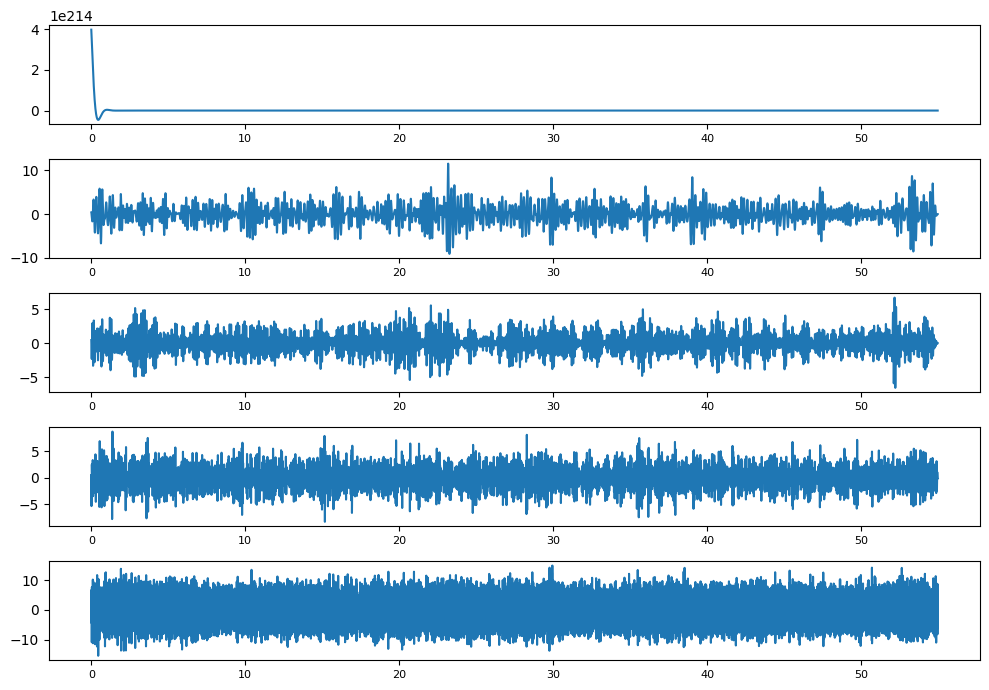

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 创建带通滤波器
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # 奈奎斯特频率
    low = lowcut / nyq  # 归一化低频
    high = highcut / nyq  # 归一化高频
    b, a = butter(order, [low, high], btype='band')
    return b, a

# 滤波函数
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 定义脑电频带
bands = {
    'Delta (0.5–4 Hz)': (0.5, 4),
    'Theta (4–8 Hz)': (4, 8),
    'Alpha (8–13 Hz)': (8, 13),
    'Beta (13–30 Hz)': (13, 30),
    'Gamma (30–100 Hz)': (30, 100)
}

# 假设 df_marker 是存储脑电数据的 DataFrame，FP1 是其中一列
fs = 1000
time = np.linspace(0, len(df_marker)/fs, len(df_marker))  # 时间轴

fp1_data = df_marker['F1']  # 获取FP1导联数据

# 绘制每个频带的波形图
plt.figure(figsize=(10, 7))

for i, (band, (lowcut, highcut)) in enumerate(bands.items()):
    filtered_data = bandpass_filter(fp1_data, lowcut, highcut, fs)
    
    plt.subplot(len(bands), 1, i+1)
    plt.plot(time, filtered_data)
#     plt.title(f'FP1 - {band} Band')
#     plt.ylabel('Amplitude (uV)')
#     plt.xlabel('Time (s)')
    plt.xticks(fontsize=8) 

plt.tight_layout()
plt.show()


# 计算PSD

- 被试'zhangbuyuan_20230801'的原始脑电数据，147、148两个session数据缺失

## 计算峰值帧附近的PSD
- 输入1min的脑电df，时间点time_point，窗口大小win，频带frequency_band，返回对应的PSD

In [7]:
# 得到的df_1min无label和emotion
def get_df_1min(selected_subject, marker):
    eeg_path = 'eeg_py\eeg_for_mne'
    selected_file = selected_subject + '.set'
    
    # 加载数据
    raw = mne.io.read_raw_eeglab(os.path.join(eeg_path, selected_file), 
        eog=(), 
        preload=False, 
        uint16_codec=None, 
        montage_units='auto', 
        verbose=None
    )

    # 删除异常值
    markers_all = list(raw.annotations.description)
    markers_retain = [str(marker) for marker in list(range(99, 149))] # 100~148
    markers_del = list(set([item for item in markers_all if item not in markers_retain]))

    to_remove = []
    for m in markers_del:
        to_remove.append(list(raw.annotations.description).index(m))
        raw.annotations.delete(to_remove[-1])

    # 转为dataframe
    df_raw = raw.to_data_frame()
    time_marker_dict = dict(zip(list(raw.annotations.onset), list(raw.annotations.description)))
    
    # 根据marker筛选数据
    df_raw.loc[:, 'marker'] = df_raw['time'].apply(lambda x: assign_marker(x, time_marker_dict))
    df_1min = df_raw[df_raw['marker']==marker]
    
    return df_1min

In [8]:
def add_label_emotion(df_1min):
    marker2label = {100: 0, 101: 1, 102: 2, 103: 3, 104: 4, 105: 5, 106: 6, 107: 7, 108: 8, 109: 1, 110: 2, 111: 3, 112: 2, 113: 4, 114: 5, 115: 6, 116: 7, 117: 8, 118: 1, 119: 2, 120: 3, 121: 4, 122: 5, 123: 3, 124: 6, 125: 7, 126: 8, 127: 1, 128: 2, 129: 3, 130: 4, 131: 5, 132: 6, 133: 7, 134: 4, 135: 8, 136: 1, 137: 2, 138: 3, 139: 4, 140: 5, 141: 6, 142: 7, 143: 8, 144: 5, 145: 6, 146: 7, 147: 8, 148: 1}
    label2emotion = {0: 'useless', 1: 'sad', 2: 'disgust', 3: 'happy', 4: 'fear', 5: 'nervous', 6: 'calm', 7: 'anger', 8: 'surprise'}

    # 定义一个函数，根据 marker 值查找对应的 label
    def marker_to_label(marker):
        return marker2label.get(int(marker), None)  # 使用 get 方法，如果找不到对应的 marker，返回 None

    # 定义一个函数，根据 label 值查找对应的 emotion
    def label_to_emotion(label):
        return label2emotion.get(label, None)  # 使用 get 方法，如果找不到对应的 label，返回 None

    # 使用 apply 函数将 marker_to_label 应用于 df_raw 的 'marker' 列，生成新的 'label' 列
    df_1min.loc[:, 'label'] = df_1min['marker'].apply(marker_to_label)
    df_1min.loc[:, 'label'] = df_1min['label'].astype(int)

    # 使用 apply 函数将 label_to_emotion 应用于 df_raw 的 'label' 列，生成新的 'emotion' 列
    df_1min.loc[:, 'emotion'] = df_1min['label'].apply(label_to_emotion)
    
    return df_1min

In [9]:
def get_psd(df_1min, time_point, win, frequency_band):
    frequency_bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 25), 'gamma': (25, 40), 'all': (1, 40)}
    f_min, f_max = frequency_bands.get(frequency_band, (None, None))
    
    if time_point - win >= 0 and time_point + win <= df_1min.shape[0]/1000:
        t1 = time_point - win
        t2 = time_point + win
        print('df_1min.iloc[int(t1*1000): int(t2*1000), 1: -8].shape:', df_1min.iloc[int(t1*1000): int(t2*1000), 1: -8].shape)
        df_eeg_select = df_1min.iloc[int(t1*1000): int(t2*1000), 1: -8].to_numpy()
        f, psd_den = signal.periodogram(df_eeg_select, fs=1000, window="boxcar", nfft=512, scaling="density", 
                                        return_onesided=False, axis=0)

        idx = np.where((f >= f_min) & (f <= f_max))[0]
        print('idx:', idx)
        
        psd_band = np.mean(psd_den[idx,:],axis=0)
        print("t1~t2之间的数据形状：", df_eeg_select.shape)
        print(f"t1~t2之间的时长：{df_eeg_select.shape[0] / 1000} s")  
        
        return psd_band

In [15]:
def assign_marker(time, time_marker_dict):
    # 获取 time_marker_dict 的 keys，并进行排序
    sorted_keys = sorted(time_marker_dict.keys())
    
    # 如果 time 小于所有的 key，返回 '100'
    if time < sorted_keys[0]:
        return '100'
    
    # 遍历 sorted_keys，找到 time 所在的区间
    for i in range(len(sorted_keys) - 1):
        if sorted_keys[i] <= time < sorted_keys[i + 1]:
            return time_marker_dict[sorted_keys[i]]
    
    # 如果 time 大于最后一个键的值，返回最后一个键对应的 value
    if time >= sorted_keys[-1]:
        return time_marker_dict[sorted_keys[-1]]
    
    return None

def find_value(dict_, partial_key):
    for key in dict_:
        if partial_key in key:
            return dict_[key]
    return None

In [80]:
selected_subject = 'yangmi_20230728'
marker = '146'

# 获取对应的apex
apex_list = find_value(subject_apextime_micro_dict, marker + '_' + selected_subject)

# 根据subject和marker筛选出对应的1min EEG数据
df_1min = get_df_1min(selected_subject, marker)
    
# 给筛选的数据增加 label 和 emotion
df_1min = add_label_emotion(df_1min)

# 给定1min EEG数据，apex的时刻，时间窗口，频带，返回对应的psd
psd_band = get_psd(df_1min, apex_list[0], 1, 'theta')
psd_band = psd_band.tolist()
print('len(psd_band):',len(psd_band))
print('psd_band:', psd_band)

Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\yangmi_20230728.fdt
df_1min.iloc[int(t1*1000): int(t2*1000), 1: -8].shape: (2000, 64)
idx: [3 4]
t1~t2之间的数据形状： (2000, 63)
t1~t2之间的时长：2.0 s
len(psd_band): 63
psd_band: [3.19775931467772, 5.339820852596761, 4.226723042446258, 2.6979116950896835, 3.145294943577387, 10.092512722542766, 5.287775805229541, 2.6700888777724625, 2.0210428311950133, 3.790982926580056, 3.2221090822867913, 4.0144777002388174, 4.270742356534241, 6.590628095928186, 7.492244487005313, 3.511439716148526, 1.1236302453623457, 1.0198111635294413, 1.893149934743809, 1.7004959611396175, 2.0982388672263204, 3.523032082655659, 2.7010124831418647, 4.848083565371168, 2.1812466877652352, 0.4782727702681954, 0.09617920650141443, 0.34051708012672843, 0.7709585320380326, 0.6596985079173969, 1.098821339683381, 3.725919591029774, 7.687157905423536, 2.287951670346376, 0.7181070657572113, 0.09574029126482958, 0.145691356357204, 0.0061728

## 计算40s的PSD

In [62]:
eeg_path = 'eeg_py\eeg_for_mne'

for dirpath, dirnames, filenames in os.walk(eeg_path):
    filenames_set = [s for s in filenames if '.set' in s]
    print('filenames_set:', filenames_set)
    print('len(filenames_set):', len(filenames_set))

filenames_set: ['fengdengfang_20230802.set', 'linjiaying_20230719.set', 'liyan_20230802.set', 'lizhuoru_20230720.set', 'lvpinxin_20230803.set', 'mayiran_20230718.set', 'wangjintao_20230719.set', 'wangshuai_20230802.set', 'wangsixian_20230719.set', 'wangxiaomin_20230718.set', 'wangziheng_20230727.set', 'wangzishan_20230717.set', 'xietao_20230803.set', 'yangmi_20230728.set', 'yansen_20230731.set', 'yuelu_20230720.set', 'zhangbuyuan_20230801.set', 'zhangdi_20230721.set', 'zhaolei_20230803.set', 'zhaoshaohua_20230801.set', 'zhengwansheng_20230718.set']
len(filenames_set): 21


In [63]:
def find_value(dict_, partial_key):
    for key in dict_:
        if partial_key in key:
            return dict_[key]
    return None

def assign_marker(time, time_marker_dict):
    # 获取 time_marker_dict 的 keys，并进行排序
    sorted_keys = sorted(time_marker_dict.keys())
    
    # 如果 time 小于所有的 key，返回 '100'
    if time < sorted_keys[0]:
        return '100'
    
    # 遍历 sorted_keys，找到 time 所在的区间
    for i in range(len(sorted_keys) - 1):
        if sorted_keys[i] <= time < sorted_keys[i + 1]:
            return time_marker_dict[sorted_keys[i]]
    
    # 如果 time 大于最后一个键的值，返回最后一个键对应的 value
    if time >= sorted_keys[-1]:
        return time_marker_dict[sorted_keys[-1]]
    
    return None

In [64]:
def get_psd_by_window(df_1min, window=1):
    frequency_bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 47)}
    
    df_eeg_select = df_1min.iloc[-40 * 1000: -1, 1: -7].to_numpy()
    
    rslt = np.zeros([1, 40// window, 310])
    
    for i in range(40 // window):
        one_secs = df_eeg_select[i*window*1000:(i+1)*window*1000+1, :]
        temp_rslt = np.zeros([62, 5])
        for bi, band in enumerate(frequency_bands.values()):
            (f_min, f_max) = band
            f, psd_den = signal.periodogram(one_secs, fs=1000, window="boxcar", nfft=512, scaling="density", 
                                            return_onesided=False, axis=0)
            
            idx = np.where((f >= f_min) & (f <= f_max))[0]
            psd_band = np.mean(psd_den[idx,:],axis=0)
            temp_rslt[:, bi] = psd_band
        
        rslt[0, i, :] = temp_rslt.flatten()
        
    # 计算非空值的均值
    non_zero_mean = np.nanmean(rslt)

    # 使用非空值的均值填充空值
    rslt[np.isnan(rslt)] = non_zero_mean

    has_nan = np.isnan(rslt).any()
    print("rslt中是否有空值：", has_nan)
    if has_nan:
        print('***************************************************************************************************')
    
    return rslt

### 保存单个.pkl文件
- 将每个.set文件的psd特征以字典的形式保存到单个.pkl文件

In [66]:
from tqdm import tqdm
import pickle

for file in tqdm(filenames_set, desc="Processing files"):
    dict_marker_psd = {}
    selected_subject = file.split('.')[0]
    print('selected_subject:', selected_subject)
    
    eeg_path = 'eeg_py\eeg_for_mne'
    selected_file = selected_subject + '.set'
    
    # 加载数据
    raw = mne.io.read_raw_eeglab(os.path.join(eeg_path, selected_file), 
        eog=(), 
        preload=False, 
        uint16_codec=None, 
        montage_units='auto', 
        verbose=None
    ).load_data().filter(l_freq=0.04, h_freq=48)

    # 删除异常值
    markers_all = list(raw.annotations.description)
    markers_retain = [str(marker) for marker in list(range(99, 149))] # 100~148
    markers_del = list(set([item for item in markers_all if item not in markers_retain]))

    to_remove = []
    for m in markers_del:
        to_remove.append(list(raw.annotations.description).index(m))
        raw.annotations.delete(to_remove[-1])

    # 转为dataframe
    df_raw = raw.to_data_frame()
    time_marker_dict = dict(zip(list(raw.annotations.onset), list(raw.annotations.description)))
    df_raw.loc[:, 'marker'] = df_raw['time'].apply(lambda x: assign_marker(x, time_marker_dict))
    
    print('Get df_raw')
    
    for marker in [str(marker) for marker in list(range(101, 149))]:
        if selected_subject == 'zhangbuyuan_20230801' and (marker == '147' or marker == '148'):
            pass
        
        else:
            # 根据marker筛选出对应的1min EEG数据
            df_1min = df_raw[df_raw['marker']==marker]

            # 给定1min EEG数据，apex的时刻，时间窗口，频带，返回对应的psd
            psd_band = get_psd_by_window(df_1min)

            marker_new = selected_subject + '_' + marker
            print('marker_new:', marker_new)
            dict_marker_psd[marker_new] = psd_band
    
    
    # 将字典保存到.pkl文件
    with open(os.path.join('psd_features', selected_subject + '.pkl'), 'wb') as f:
        pickle.dump(dict_marker_psd, f)
        
    print(f'Process file {file} success!')

Processing files:   0%|                                                                         | 0/21 [00:00<?, ?it/s]

selected_subject: fengdengfang_20230802
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\fengdengfang_20230802.fdt
Reading 0 ... 4402199  =      0.000 ...  4402.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.8s


Get df_raw
rslt中是否有空值： False
marker_new: fengdengfang_20230802_101
rslt中是否有空值： False
marker_new: fengdengfang_20230802_102
rslt中是否有空值： False
marker_new: fengdengfang_20230802_103
rslt中是否有空值： False
marker_new: fengdengfang_20230802_104
rslt中是否有空值： False
marker_new: fengdengfang_20230802_105
rslt中是否有空值： False
marker_new: fengdengfang_20230802_106
rslt中是否有空值： False
marker_new: fengdengfang_20230802_107
rslt中是否有空值： False
marker_new: fengdengfang_20230802_108
rslt中是否有空值： False
marker_new: fengdengfang_20230802_109
rslt中是否有空值： False
marker_new: fengdengfang_20230802_110
rslt中是否有空值： False
marker_new: fengdengfang_20230802_111
rslt中是否有空值： False
marker_new: fengdengfang_20230802_112
rslt中是否有空值： False
marker_new: fengdengfang_20230802_113
rslt中是否有空值： False
marker_new: fengdengfang_20230802_114
rslt中是否有空值： False
marker_new: fengdengfang_20230802_115
rslt中是否有空值： False
marker_new: fengdengfang_20230802_116
rslt中是否有空值： False
marker_new: fengdengfang_20230802_117
rslt中是否有空值： False
marker_new: fengden

Processing files:   5%|███                                                              | 1/21 [01:18<26:12, 78.64s/it]

rslt中是否有空值： False
marker_new: fengdengfang_20230802_148
Process file fengdengfang_20230802.set success!
selected_subject: linjiaying_20230719
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\linjiaying_20230719.fdt
Reading 0 ... 3968999  =      0.000 ...  3968.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Get df_raw
rslt中是否有空值： False
marker_new: linjiaying_20230719_101
rslt中是否有空值： False
marker_new: linjiaying_20230719_102
rslt中是否有空值： False
marker_new: linjiaying_20230719_103
rslt中是否有空值： False
marker_new: linjiaying_20230719_104
rslt中是否有空值： False
marker_new: linjiaying_20230719_105
rslt中是否有空值： False
marker_new: linjiaying_20230719_106
rslt中是否有空值： False
marker_new: linjiaying_20230719_107
rslt中是否有空值： False
marker_new: linjiaying_20230719_108
rslt中是否有空值： False
marker_new: linjiaying_20230719_109
rslt中是否有空值： False
marker_new: linjiaying_20230719_110
rslt中是否有空值： False
marker_new: linjiaying_20230719_111
rslt中是否有空值： False
marker_new: linjiaying_20230719_112
rslt中是否有空值： False
marker_new: linjiaying_20230719_113
rslt中是否有空值： False
marker_new: linjiaying_20230719_114
rslt中是否有空值： False
marker_new: linjiaying_20230719_115
rslt中是否有空值： False
marker_new: linjiaying_20230719_116
rslt中是否有空值： False
marker_new: linjiaying_20230719_117
rslt中是否有空值： False
marker_new: linjiaying_20230719_118
rslt中是否有空值： False

Processing files:  10%|██████▏                                                          | 2/21 [02:37<24:53, 78.63s/it]

rslt中是否有空值： False
marker_new: linjiaying_20230719_148
Process file linjiaying_20230719.set success!
selected_subject: liyan_20230802
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\liyan_20230802.fdt
Reading 0 ... 4444199  =      0.000 ...  4444.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.9s


Get df_raw
rslt中是否有空值： False
marker_new: liyan_20230802_101
rslt中是否有空值： False
marker_new: liyan_20230802_102
rslt中是否有空值： False
marker_new: liyan_20230802_103
rslt中是否有空值： False
marker_new: liyan_20230802_104
rslt中是否有空值： False
marker_new: liyan_20230802_105
rslt中是否有空值： False
marker_new: liyan_20230802_106
rslt中是否有空值： False
marker_new: liyan_20230802_107
rslt中是否有空值： False
marker_new: liyan_20230802_108
rslt中是否有空值： False
marker_new: liyan_20230802_109
rslt中是否有空值： False
marker_new: liyan_20230802_110
rslt中是否有空值： False
marker_new: liyan_20230802_111
rslt中是否有空值： False
marker_new: liyan_20230802_112
rslt中是否有空值： False
marker_new: liyan_20230802_113
rslt中是否有空值： False
marker_new: liyan_20230802_114
rslt中是否有空值： False
marker_new: liyan_20230802_115
rslt中是否有空值： False
marker_new: liyan_20230802_116
rslt中是否有空值： False
marker_new: liyan_20230802_117
rslt中是否有空值： False
marker_new: liyan_20230802_118
rslt中是否有空值： False
marker_new: liyan_20230802_119
rslt中是否有空值： False
marker_new: liyan_20230802_120
rslt中是否有空

Processing files:  14%|█████████▎                                                       | 3/21 [04:04<24:46, 82.56s/it]

rslt中是否有空值： False
marker_new: liyan_20230802_148
Process file liyan_20230802.set success!
selected_subject: lizhuoru_20230720
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\lizhuoru_20230720.fdt
Reading 0 ... 4684199  =      0.000 ...  4684.199 secs...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_31008\3479991421.py:13: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_path, selected_file),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31008\3479991421.py:13: RuntimeWarning: At least one event has a sample index of -1. This usually is a consequence of how eeglab handles event latency after resampling - especially when you had a boundary event at the beginning of the file. Please make sure that the events at the very beginning of your EEGLAB file can be safely dropped (e.g., because they are boundary events).
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_path, selected_file),


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.3s


Get df_raw
rslt中是否有空值： False
marker_new: lizhuoru_20230720_101
rslt中是否有空值： False
marker_new: lizhuoru_20230720_102
rslt中是否有空值： False
marker_new: lizhuoru_20230720_103
rslt中是否有空值： False
marker_new: lizhuoru_20230720_104
rslt中是否有空值： False
marker_new: lizhuoru_20230720_105
rslt中是否有空值： False
marker_new: lizhuoru_20230720_106
rslt中是否有空值： False
marker_new: lizhuoru_20230720_107
rslt中是否有空值： False
marker_new: lizhuoru_20230720_108
rslt中是否有空值： False
marker_new: lizhuoru_20230720_109
rslt中是否有空值： False
marker_new: lizhuoru_20230720_110
rslt中是否有空值： False
marker_new: lizhuoru_20230720_111
rslt中是否有空值： False
marker_new: lizhuoru_20230720_112
rslt中是否有空值： False
marker_new: lizhuoru_20230720_113
rslt中是否有空值： False
marker_new: lizhuoru_20230720_114
rslt中是否有空值： False
marker_new: lizhuoru_20230720_115
rslt中是否有空值： False
marker_new: lizhuoru_20230720_116
rslt中是否有空值： False
marker_new: lizhuoru_20230720_117
rslt中是否有空值： False
marker_new: lizhuoru_20230720_118
rslt中是否有空值： False
marker_new: lizhuoru_20230720_119
r

Processing files:  19%|████████████▏                                                   | 4/21 [06:28<30:15, 106.82s/it]

rslt中是否有空值： False
marker_new: lizhuoru_20230720_148
Process file lizhuoru_20230720.set success!
selected_subject: lvpinxin_20230803
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\lvpinxin_20230803.fdt
Reading 0 ... 3477599  =      0.000 ...  3477.599 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Get df_raw
rslt中是否有空值： False
marker_new: lvpinxin_20230803_101
rslt中是否有空值： False
marker_new: lvpinxin_20230803_102
rslt中是否有空值： False
marker_new: lvpinxin_20230803_103
rslt中是否有空值： False
marker_new: lvpinxin_20230803_104
rslt中是否有空值： False
marker_new: lvpinxin_20230803_105
rslt中是否有空值： False
marker_new: lvpinxin_20230803_106
rslt中是否有空值： False
marker_new: lvpinxin_20230803_107
rslt中是否有空值： False
marker_new: lvpinxin_20230803_108
rslt中是否有空值： False
marker_new: lvpinxin_20230803_109
rslt中是否有空值： False
marker_new: lvpinxin_20230803_110
rslt中是否有空值： False
marker_new: lvpinxin_20230803_111
rslt中是否有空值： False
marker_new: lvpinxin_20230803_112
rslt中是否有空值： False
marker_new: lvpinxin_20230803_113
rslt中是否有空值： False
marker_new: lvpinxin_20230803_114
rslt中是否有空值： False
marker_new: lvpinxin_20230803_115
rslt中是否有空值： False
marker_new: lvpinxin_20230803_116
rslt中是否有空值： False
marker_new: lvpinxin_20230803_117
rslt中是否有空值： False
marker_new: lvpinxin_20230803_118
rslt中是否有空值： False
marker_new: lvpinxin_20230803_119
r

Processing files:  24%|███████████████▍                                                 | 5/21 [07:37<24:49, 93.10s/it]

rslt中是否有空值： False
marker_new: lvpinxin_20230803_148
Process file lvpinxin_20230803.set success!
selected_subject: mayiran_20230718
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\mayiran_20230718.fdt
Reading 0 ... 4078199  =      0.000 ...  4078.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Get df_raw
rslt中是否有空值： False
marker_new: mayiran_20230718_101
rslt中是否有空值： False
marker_new: mayiran_20230718_102
rslt中是否有空值： False
marker_new: mayiran_20230718_103
rslt中是否有空值： False
marker_new: mayiran_20230718_104
rslt中是否有空值： False
marker_new: mayiran_20230718_105
rslt中是否有空值： False
marker_new: mayiran_20230718_106
rslt中是否有空值： False
marker_new: mayiran_20230718_107
rslt中是否有空值： False
marker_new: mayiran_20230718_108
rslt中是否有空值： False
marker_new: mayiran_20230718_109
rslt中是否有空值： False
marker_new: mayiran_20230718_110
rslt中是否有空值： False
marker_new: mayiran_20230718_111
rslt中是否有空值： False
marker_new: mayiran_20230718_112
rslt中是否有空值： False
marker_new: mayiran_20230718_113
rslt中是否有空值： False
marker_new: mayiran_20230718_114
rslt中是否有空值： False
marker_new: mayiran_20230718_115
rslt中是否有空值： False
marker_new: mayiran_20230718_116
rslt中是否有空值： False
marker_new: mayiran_20230718_117
rslt中是否有空值： False
marker_new: mayiran_20230718_118
rslt中是否有空值： False
marker_new: mayiran_20230718_119
rslt中是否有空值： False
ma

Processing files:  29%|██████████████████▌                                              | 6/21 [08:57<22:09, 88.62s/it]

rslt中是否有空值： False
marker_new: mayiran_20230718_148
Process file mayiran_20230718.set success!
selected_subject: wangjintao_20230719
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\wangjintao_20230719.fdt
Reading 0 ... 3691199  =      0.000 ...  3691.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Get df_raw
rslt中是否有空值： False
marker_new: wangjintao_20230719_101
rslt中是否有空值： False
marker_new: wangjintao_20230719_102
rslt中是否有空值： False
marker_new: wangjintao_20230719_103
rslt中是否有空值： False
marker_new: wangjintao_20230719_104
rslt中是否有空值： False
marker_new: wangjintao_20230719_105
rslt中是否有空值： False
marker_new: wangjintao_20230719_106
rslt中是否有空值： False
marker_new: wangjintao_20230719_107
rslt中是否有空值： False
marker_new: wangjintao_20230719_108
rslt中是否有空值： False
marker_new: wangjintao_20230719_109
rslt中是否有空值： False
marker_new: wangjintao_20230719_110
rslt中是否有空值： False
marker_new: wangjintao_20230719_111
rslt中是否有空值： False
marker_new: wangjintao_20230719_112
rslt中是否有空值： False
marker_new: wangjintao_20230719_113
rslt中是否有空值： False
marker_new: wangjintao_20230719_114
rslt中是否有空值： False
marker_new: wangjintao_20230719_115
rslt中是否有空值： False
marker_new: wangjintao_20230719_116
rslt中是否有空值： False
marker_new: wangjintao_20230719_117
rslt中是否有空值： False
marker_new: wangjintao_20230719_118
rslt中是否有空值： False

Processing files:  33%|█████████████████████▋                                           | 7/21 [10:12<19:41, 84.38s/it]

rslt中是否有空值： False
marker_new: wangjintao_20230719_148
Process file wangjintao_20230719.set success!
selected_subject: wangshuai_20230802
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\wangshuai_20230802.fdt


C:\Users\Administrator\AppData\Local\Temp\ipykernel_31008\3479991421.py:13: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_path, selected_file),


Reading 0 ... 3769199  =      0.000 ...  3769.199 secs...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_31008\3479991421.py:13: RuntimeWarning: At least one event has a sample index of -1. This usually is a consequence of how eeglab handles event latency after resampling - especially when you had a boundary event at the beginning of the file. Please make sure that the events at the very beginning of your EEGLAB file can be safely dropped (e.g., because they are boundary events).
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_path, selected_file),


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Get df_raw
rslt中是否有空值： False
marker_new: wangshuai_20230802_101
rslt中是否有空值： False
marker_new: wangshuai_20230802_102
rslt中是否有空值： False
marker_new: wangshuai_20230802_103
rslt中是否有空值： False
marker_new: wangshuai_20230802_104
rslt中是否有空值： False
marker_new: wangshuai_20230802_105
rslt中是否有空值： False
marker_new: wangshuai_20230802_106
rslt中是否有空值： False
marker_new: wangshuai_20230802_107
rslt中是否有空值： False
marker_new: wangshuai_20230802_108
rslt中是否有空值： False
marker_new: wangshuai_20230802_109
rslt中是否有空值： False
marker_new: wangshuai_20230802_110
rslt中是否有空值： False
marker_new: wangshuai_20230802_111
rslt中是否有空值： False
marker_new: wangshuai_20230802_112
rslt中是否有空值： False
marker_new: wangshuai_20230802_113
rslt中是否有空值： False
marker_new: wangshuai_20230802_114
rslt中是否有空值： False
marker_new: wangshuai_20230802_115
rslt中是否有空值： False
marker_new: wangshuai_20230802_116
rslt中是否有空值： False
marker_new: wangshuai_20230802_117
rslt中是否有空值： False
marker_new: wangshuai_20230802_118
rslt中是否有空值： False
marker_new: wangs

Processing files:  38%|████████████████████████▊                                        | 8/21 [11:28<17:38, 81.44s/it]

rslt中是否有空值： False
marker_new: wangshuai_20230802_148
Process file wangshuai_20230802.set success!
selected_subject: wangsixian_20230719
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\wangsixian_20230719.fdt
Reading 0 ... 4073099  =      0.000 ...  4073.099 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.6s


Get df_raw
rslt中是否有空值： False
marker_new: wangsixian_20230719_101
rslt中是否有空值： False
marker_new: wangsixian_20230719_102
rslt中是否有空值： False
marker_new: wangsixian_20230719_103
rslt中是否有空值： False
marker_new: wangsixian_20230719_104
rslt中是否有空值： False
marker_new: wangsixian_20230719_105
rslt中是否有空值： False
marker_new: wangsixian_20230719_106
rslt中是否有空值： False
marker_new: wangsixian_20230719_107
rslt中是否有空值： False
marker_new: wangsixian_20230719_108
rslt中是否有空值： False
marker_new: wangsixian_20230719_109
rslt中是否有空值： False
marker_new: wangsixian_20230719_110
rslt中是否有空值： False
marker_new: wangsixian_20230719_111
rslt中是否有空值： False
marker_new: wangsixian_20230719_112
rslt中是否有空值： False
marker_new: wangsixian_20230719_113
rslt中是否有空值： False
marker_new: wangsixian_20230719_114
rslt中是否有空值： False
marker_new: wangsixian_20230719_115
rslt中是否有空值： False
marker_new: wangsixian_20230719_116
rslt中是否有空值： False
marker_new: wangsixian_20230719_117
rslt中是否有空值： False
marker_new: wangsixian_20230719_118
rslt中是否有空值： False

Processing files:  43%|███████████████████████████▊                                     | 9/21 [12:50<16:20, 81.71s/it]

rslt中是否有空值： False
marker_new: wangsixian_20230719_148
Process file wangsixian_20230719.set success!
selected_subject: wangxiaomin_20230718
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\wangxiaomin_20230718.fdt
Reading 0 ... 3400499  =      0.000 ...  3400.499 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Get df_raw
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_101
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_102
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_103
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_104
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_105
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_106
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_107
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_108
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_109
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_110
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_111
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_112
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_113
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_114
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_115
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_116
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_117
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_118

Processing files:  48%|██████████████████████████████▍                                 | 10/21 [14:01<14:23, 78.47s/it]

rslt中是否有空值： False
marker_new: wangxiaomin_20230718_147
rslt中是否有空值： False
marker_new: wangxiaomin_20230718_148
Process file wangxiaomin_20230718.set success!
selected_subject: wangziheng_20230727
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\wangziheng_20230727.fdt
Reading 0 ... 4010999  =      0.000 ...  4010.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Get df_raw
rslt中是否有空值： False
marker_new: wangziheng_20230727_101
rslt中是否有空值： False
marker_new: wangziheng_20230727_102
rslt中是否有空值： False
marker_new: wangziheng_20230727_103
rslt中是否有空值： False
marker_new: wangziheng_20230727_104
rslt中是否有空值： False
marker_new: wangziheng_20230727_105
rslt中是否有空值： False
marker_new: wangziheng_20230727_106
rslt中是否有空值： False
marker_new: wangziheng_20230727_107
rslt中是否有空值： False
marker_new: wangziheng_20230727_108
rslt中是否有空值： False
marker_new: wangziheng_20230727_109
rslt中是否有空值： False
marker_new: wangziheng_20230727_110
rslt中是否有空值： False
marker_new: wangziheng_20230727_111
rslt中是否有空值： False
marker_new: wangziheng_20230727_112
rslt中是否有空值： False
marker_new: wangziheng_20230727_113
rslt中是否有空值： False
marker_new: wangziheng_20230727_114
rslt中是否有空值： False
marker_new: wangziheng_20230727_115
rslt中是否有空值： False
marker_new: wangziheng_20230727_116
rslt中是否有空值： False
marker_new: wangziheng_20230727_117
rslt中是否有空值： False
marker_new: wangziheng_20230727_118
rslt中是否有空值： False

Processing files:  52%|█████████████████████████████████▌                              | 11/21 [15:18<12:58, 77.89s/it]

rslt中是否有空值： False
marker_new: wangziheng_20230727_148
Process file wangziheng_20230727.set success!
selected_subject: wangzishan_20230717
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\wangzishan_20230717.fdt
Reading 0 ... 4142199  =      0.000 ...  4142.199 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.6s


Get df_raw
rslt中是否有空值： False
marker_new: wangzishan_20230717_101
rslt中是否有空值： False
marker_new: wangzishan_20230717_102
rslt中是否有空值： False
marker_new: wangzishan_20230717_103
rslt中是否有空值： False
marker_new: wangzishan_20230717_104
rslt中是否有空值： False
marker_new: wangzishan_20230717_105
rslt中是否有空值： False
marker_new: wangzishan_20230717_106
rslt中是否有空值： False
marker_new: wangzishan_20230717_107
rslt中是否有空值： False
marker_new: wangzishan_20230717_108
rslt中是否有空值： False
marker_new: wangzishan_20230717_109
rslt中是否有空值： False
marker_new: wangzishan_20230717_110
rslt中是否有空值： False
marker_new: wangzishan_20230717_111
rslt中是否有空值： False
marker_new: wangzishan_20230717_112
rslt中是否有空值： False
marker_new: wangzishan_20230717_113
rslt中是否有空值： False
marker_new: wangzishan_20230717_114
rslt中是否有空值： False
marker_new: wangzishan_20230717_115
rslt中是否有空值： False
marker_new: wangzishan_20230717_116
rslt中是否有空值： False
marker_new: wangzishan_20230717_117
rslt中是否有空值： False
marker_new: wangzishan_20230717_118
rslt中是否有空值： False

Processing files:  57%|████████████████████████████████████▌                           | 12/21 [16:41<11:55, 79.49s/it]

rslt中是否有空值： False
marker_new: wangzishan_20230717_148
Process file wangzishan_20230717.set success!
selected_subject: xietao_20230803
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\xietao_20230803.fdt
Reading 0 ... 3782999  =      0.000 ...  3782.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Get df_raw
rslt中是否有空值： False
marker_new: xietao_20230803_101
rslt中是否有空值： False
marker_new: xietao_20230803_102
rslt中是否有空值： False
marker_new: xietao_20230803_103
rslt中是否有空值： False
marker_new: xietao_20230803_104
rslt中是否有空值： False
marker_new: xietao_20230803_105
rslt中是否有空值： False
marker_new: xietao_20230803_106
rslt中是否有空值： False
marker_new: xietao_20230803_107
rslt中是否有空值： False
marker_new: xietao_20230803_108
rslt中是否有空值： False
marker_new: xietao_20230803_109
rslt中是否有空值： False
marker_new: xietao_20230803_110
rslt中是否有空值： False
marker_new: xietao_20230803_111
rslt中是否有空值： False
marker_new: xietao_20230803_112
rslt中是否有空值： False
marker_new: xietao_20230803_113
rslt中是否有空值： False
marker_new: xietao_20230803_114
rslt中是否有空值： False
marker_new: xietao_20230803_115
rslt中是否有空值： False
marker_new: xietao_20230803_116
rslt中是否有空值： False
marker_new: xietao_20230803_117
rslt中是否有空值： False
marker_new: xietao_20230803_118
rslt中是否有空值： False
marker_new: xietao_20230803_119
rslt中是否有空值： False
marker_new: xietao_20

Processing files:  62%|███████████████████████████████████████▌                        | 13/21 [17:56<10:26, 78.31s/it]

rslt中是否有空值： False
marker_new: xietao_20230803_148
Process file xietao_20230803.set success!
selected_subject: yangmi_20230728
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\yangmi_20230728.fdt
Reading 0 ... 3938699  =      0.000 ...  3938.699 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Get df_raw
rslt中是否有空值： False
marker_new: yangmi_20230728_101
rslt中是否有空值： False
marker_new: yangmi_20230728_102
rslt中是否有空值： False
marker_new: yangmi_20230728_103
rslt中是否有空值： False
marker_new: yangmi_20230728_104
rslt中是否有空值： False
marker_new: yangmi_20230728_105
rslt中是否有空值： False
marker_new: yangmi_20230728_106
rslt中是否有空值： False
marker_new: yangmi_20230728_107
rslt中是否有空值： False
marker_new: yangmi_20230728_108
rslt中是否有空值： False
marker_new: yangmi_20230728_109
rslt中是否有空值： False
marker_new: yangmi_20230728_110
rslt中是否有空值： False
marker_new: yangmi_20230728_111
rslt中是否有空值： False
marker_new: yangmi_20230728_112
rslt中是否有空值： False
marker_new: yangmi_20230728_113
rslt中是否有空值： False
marker_new: yangmi_20230728_114
rslt中是否有空值： False
marker_new: yangmi_20230728_115
rslt中是否有空值： False
marker_new: yangmi_20230728_116
rslt中是否有空值： False
marker_new: yangmi_20230728_117
rslt中是否有空值： False
marker_new: yangmi_20230728_118
rslt中是否有空值： False
marker_new: yangmi_20230728_119
rslt中是否有空值： False
marker_new: yangmi_20

Processing files:  67%|██████████████████████████████████████████▋                     | 14/21 [19:11<09:01, 77.34s/it]

rslt中是否有空值： False
marker_new: yangmi_20230728_148
Process file yangmi_20230728.set success!
selected_subject: yansen_20230731
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\yansen_20230731.fdt
Reading 0 ... 3765599  =      0.000 ...  3765.599 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Get df_raw
rslt中是否有空值： False
marker_new: yansen_20230731_101
rslt中是否有空值： False
marker_new: yansen_20230731_102
rslt中是否有空值： False
marker_new: yansen_20230731_103
rslt中是否有空值： False
marker_new: yansen_20230731_104
rslt中是否有空值： False
marker_new: yansen_20230731_105
rslt中是否有空值： False
marker_new: yansen_20230731_106
rslt中是否有空值： False
marker_new: yansen_20230731_107
rslt中是否有空值： False
marker_new: yansen_20230731_108
rslt中是否有空值： False
marker_new: yansen_20230731_109
rslt中是否有空值： False
marker_new: yansen_20230731_110
rslt中是否有空值： False
marker_new: yansen_20230731_111
rslt中是否有空值： False
marker_new: yansen_20230731_112
rslt中是否有空值： False
marker_new: yansen_20230731_113
rslt中是否有空值： False
marker_new: yansen_20230731_114
rslt中是否有空值： False
marker_new: yansen_20230731_115
rslt中是否有空值： False
marker_new: yansen_20230731_116
rslt中是否有空值： False
marker_new: yansen_20230731_117
rslt中是否有空值： False
marker_new: yansen_20230731_118
rslt中是否有空值： False
marker_new: yansen_20230731_119
rslt中是否有空值： False
marker_new: yansen_20

Processing files:  71%|█████████████████████████████████████████████▋                  | 15/21 [20:25<07:36, 76.07s/it]

rslt中是否有空值： False
marker_new: yansen_20230731_148
Process file yansen_20230731.set success!
selected_subject: yuelu_20230720
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\yuelu_20230720.fdt
Reading 0 ... 3542999  =      0.000 ...  3542.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Get df_raw
rslt中是否有空值： False
marker_new: yuelu_20230720_101
rslt中是否有空值： False
marker_new: yuelu_20230720_102
rslt中是否有空值： False
marker_new: yuelu_20230720_103
rslt中是否有空值： False
marker_new: yuelu_20230720_104
rslt中是否有空值： False
marker_new: yuelu_20230720_105
rslt中是否有空值： False
marker_new: yuelu_20230720_106
rslt中是否有空值： False
marker_new: yuelu_20230720_107


D:\ProgramData\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\ProgramData\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


rslt中是否有空值： False
marker_new: yuelu_20230720_108
rslt中是否有空值： False
marker_new: yuelu_20230720_109
rslt中是否有空值： False
marker_new: yuelu_20230720_110
rslt中是否有空值： False
marker_new: yuelu_20230720_111
rslt中是否有空值： False
marker_new: yuelu_20230720_112
rslt中是否有空值： False
marker_new: yuelu_20230720_113
rslt中是否有空值： False
marker_new: yuelu_20230720_114
rslt中是否有空值： False
marker_new: yuelu_20230720_115
rslt中是否有空值： False
marker_new: yuelu_20230720_116
rslt中是否有空值： False
marker_new: yuelu_20230720_117
rslt中是否有空值： False
marker_new: yuelu_20230720_118
rslt中是否有空值： False
marker_new: yuelu_20230720_119
rslt中是否有空值： False
marker_new: yuelu_20230720_120
rslt中是否有空值： False
marker_new: yuelu_20230720_121
rslt中是否有空值： False
marker_new: yuelu_20230720_122
rslt中是否有空值： False
marker_new: yuelu_20230720_123
rslt中是否有空值： False
marker_new: yuelu_20230720_124
rslt中是否有空值： False
marker_new: yuelu_20230720_125
rslt中是否有空值： False
marker_new: yuelu_20230720_126
rslt中是否有空值： False
marker_new: yuelu_20230720_127
rslt中是否有空值： False
ma

Processing files:  76%|████████████████████████████████████████████████▊               | 16/21 [21:34<06:10, 74.06s/it]

rslt中是否有空值： False
marker_new: yuelu_20230720_148
Process file yuelu_20230720.set success!
selected_subject: zhangbuyuan_20230801
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\zhangbuyuan_20230801.fdt
Reading 0 ... 3542999  =      0.000 ...  3542.999 secs...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_31008\3479991421.py:13: RuntimeWarning: Omitted 5 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_path, selected_file),


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Get df_raw
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_101
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_102
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_103
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_104
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_105
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_106
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_107
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_108
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_109
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_110
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_111
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_112
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_113
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_114
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_115
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_116
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_117
rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_118

D:\ProgramData\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\ProgramData\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Processing files:  81%|███████████████████████████████████████████████████▊            | 17/21 [22:41<04:47, 71.85s/it]

rslt中是否有空值： False
marker_new: zhangbuyuan_20230801_146
Process file zhangbuyuan_20230801.set success!
selected_subject: zhangdi_20230721
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\zhangdi_20230721.fdt
Reading 0 ... 3721299  =      0.000 ...  3721.299 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Get df_raw
rslt中是否有空值： False
marker_new: zhangdi_20230721_101
rslt中是否有空值： False
marker_new: zhangdi_20230721_102
rslt中是否有空值： False
marker_new: zhangdi_20230721_103
rslt中是否有空值： False
marker_new: zhangdi_20230721_104
rslt中是否有空值： False
marker_new: zhangdi_20230721_105
rslt中是否有空值： False
marker_new: zhangdi_20230721_106
rslt中是否有空值： False
marker_new: zhangdi_20230721_107
rslt中是否有空值： False
marker_new: zhangdi_20230721_108
rslt中是否有空值： False
marker_new: zhangdi_20230721_109
rslt中是否有空值： False
marker_new: zhangdi_20230721_110
rslt中是否有空值： False
marker_new: zhangdi_20230721_111
rslt中是否有空值： False
marker_new: zhangdi_20230721_112
rslt中是否有空值： False
marker_new: zhangdi_20230721_113
rslt中是否有空值： False
marker_new: zhangdi_20230721_114
rslt中是否有空值： False
marker_new: zhangdi_20230721_115
rslt中是否有空值： False
marker_new: zhangdi_20230721_116
rslt中是否有空值： False
marker_new: zhangdi_20230721_117
rslt中是否有空值： False
marker_new: zhangdi_20230721_118
rslt中是否有空值： False
marker_new: zhangdi_20230721_119
rslt中是否有空值： False
ma

Processing files:  86%|██████████████████████████████████████████████████████▊         | 18/21 [23:54<03:36, 72.27s/it]

rslt中是否有空值： False
marker_new: zhangdi_20230721_148
Process file zhangdi_20230721.set success!
selected_subject: zhaolei_20230803
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\zhaolei_20230803.fdt
Reading 0 ... 4035899  =      0.000 ...  4035.899 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Get df_raw
rslt中是否有空值： False
marker_new: zhaolei_20230803_101
rslt中是否有空值： False
marker_new: zhaolei_20230803_102
rslt中是否有空值： False
marker_new: zhaolei_20230803_103
rslt中是否有空值： False
marker_new: zhaolei_20230803_104
rslt中是否有空值： False
marker_new: zhaolei_20230803_105
rslt中是否有空值： False
marker_new: zhaolei_20230803_106
rslt中是否有空值： False
marker_new: zhaolei_20230803_107
rslt中是否有空值： False
marker_new: zhaolei_20230803_108
rslt中是否有空值： False
marker_new: zhaolei_20230803_109
rslt中是否有空值： False
marker_new: zhaolei_20230803_110
rslt中是否有空值： False
marker_new: zhaolei_20230803_111
rslt中是否有空值： False
marker_new: zhaolei_20230803_112
rslt中是否有空值： False
marker_new: zhaolei_20230803_113
rslt中是否有空值： False
marker_new: zhaolei_20230803_114
rslt中是否有空值： False
marker_new: zhaolei_20230803_115
rslt中是否有空值： False
marker_new: zhaolei_20230803_116
rslt中是否有空值： False
marker_new: zhaolei_20230803_117
rslt中是否有空值： False
marker_new: zhaolei_20230803_118
rslt中是否有空值： False
marker_new: zhaolei_20230803_119
rslt中是否有空值： False
ma

Processing files:  90%|█████████████████████████████████████████████████████████▉      | 19/21 [25:13<02:28, 74.43s/it]

rslt中是否有空值： False
marker_new: zhaolei_20230803_148
Process file zhaolei_20230803.set success!
selected_subject: zhaoshaohua_20230801
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\zhaoshaohua_20230801.fdt
Reading 0 ... 4163399  =      0.000 ...  4163.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.5s


Get df_raw
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_101
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_102
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_103
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_104
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_105
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_106
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_107
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_108
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_109
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_110
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_111
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_112
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_113
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_114
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_115
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_116
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_117
rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_118

Processing files:  95%|████████████████████████████████████████████████████████████▉   | 20/21 [26:34<01:16, 76.35s/it]

rslt中是否有空值： False
marker_new: zhaoshaohua_20230801_148
Process file zhaoshaohua_20230801.set success!
selected_subject: zhengwansheng_20230718
Reading E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\eeg_py\eeg_for_mne\zhengwansheng_20230718.fdt
Reading 0 ... 3995399  =      0.000 ...  3995.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.04 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.04
- Lower transition bandwidth: 0.04 Hz (-6 dB cutoff frequency: 0.02 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 82501 samples (82.501 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Get df_raw
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_101
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_102
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_103
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_104
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_105
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_106
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_107
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_108
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_109
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_110
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_111
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_112
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_113
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_114
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_115
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_116
rslt中是否有空值： False
marker_new: zhengwansheng_20230718_117
rslt中是否有空值： False
ma

Processing files: 100%|████████████████████████████████████████████████████████████████| 21/21 [27:54<00:00, 79.72s/it]

rslt中是否有空值： False
marker_new: zhengwansheng_20230718_148
Process file zhengwansheng_20230718.set success!


- 打开一个.pkl文件

In [162]:
# 从单个.pkl文件中加载数据
with open('psd_features/' + 'fengdengfang_20230802.pkl', 'rb') as f:
    data = pickle.load(f)
    
data.keys()

dict_keys(['fengdengfang_20230802_101', 'fengdengfang_20230802_102', 'fengdengfang_20230802_103', 'fengdengfang_20230802_104', 'fengdengfang_20230802_105', 'fengdengfang_20230802_106', 'fengdengfang_20230802_107', 'fengdengfang_20230802_108', 'fengdengfang_20230802_109', 'fengdengfang_20230802_110', 'fengdengfang_20230802_111', 'fengdengfang_20230802_112', 'fengdengfang_20230802_113', 'fengdengfang_20230802_114', 'fengdengfang_20230802_115', 'fengdengfang_20230802_116', 'fengdengfang_20230802_117', 'fengdengfang_20230802_118', 'fengdengfang_20230802_119', 'fengdengfang_20230802_120', 'fengdengfang_20230802_121', 'fengdengfang_20230802_122', 'fengdengfang_20230802_123', 'fengdengfang_20230802_124', 'fengdengfang_20230802_125', 'fengdengfang_20230802_126', 'fengdengfang_20230802_127', 'fengdengfang_20230802_128', 'fengdengfang_20230802_129', 'fengdengfang_20230802_130', 'fengdengfang_20230802_131', 'fengdengfang_20230802_132', 'fengdengfang_20230802_133', 'fengdengfang_20230802_134', 'fe

### 将全部.pkl文件合并为一个

In [75]:
import os
import pickle

# 合并多个.pkl文件到一个列表中
def merge_pkl_files(directory):
    # 获取目录下所有的.pkl文件
    pkl_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    merged_data = []
    for file in pkl_files:
        file_path = os.path.join(directory, file)
        # 从单个.pkl文件中加载数据
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        merged_data.append(data)
        
    merged_file = directory + '/'+ 'merged_data.pkl'
    # 多个字典合并成一个字典
    merged_dict = {k: v for d in merged_data for k, v in d.items()}
    
    with open(merged_file, 'wb') as f:
        pickle.dump(merged_dict, f)
    
directory = 'psd_features'  # .pkl文件所在的目录
merged_data = merge_pkl_files(directory)
print('合并完成，存入merged_data.pkl')

合并完成，存入merged_data.pkl


# 分类模型

## EEG-only

In [2]:
from torch.nn.utils import weight_norm
from functools import partial
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.autograd import Function
from timm.models.vision_transformer import PatchEmbed, Block, Mlp
import numpy as np
import argparse

In [3]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class PSD_PLV_CL(nn.Module):

    def __init__(self, psd_features, plv_features):
        super().__init__()

        self.psd_features = psd_features
        self.plv_features = plv_features

        self.psd_AutoEncoder = AutoEncoder(psd_features)
        self.plv_AutoEncoder = AutoEncoder(plv_features)

    def info_nce_loss(self, f_psd, f_plv, temperature = 0.01):
        """
            f_psd: (batch, dim)
            f_plv: (batch, dim)
        """
        similarity_matrix = torch.matmul(f_psd, f_plv.T)
        labels = torch.eye(similarity_matrix.shape[0], dtype=torch.bool).to('cuda')

        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([negatives, positives], dim=1)
        # The label means the last column contain the positive pairs
        labels = torch.ones(logits.shape[0], dtype=torch.long)*(logits.shape[1]-1)
        labels = labels.to('cuda')

        logits = logits / temperature
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        return loss

    def forward(self, x, label=None):

        psd, plv = x[:, :self.psd_features], x[:, self.psd_features:self.psd_features+self.plv_features]

        psd_fea = self.psd_AutoEncoder.forward_encoder(psd)
        plv_fea = self.plv_AutoEncoder.forward_encoder(plv)

        loss_nec = self.info_nce_loss(psd_fea, plv_fea)

        return loss_nec, psd_fea + plv_fea

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class ME_v2_TCN(nn.Module):
    """ A Multi-task and Multi-phase Emotional EEG Learning Framework, (mmee learning framework)
        MMOE + LSTM
    """    
    def __init__(self, 
                 in_fea=300,
                 tcn_depth = 1,
                 hidden_neuron = 128,
                 num_class=8,
                 args=None):
        super().__init__()
        
        self.gate_lstm_c_enc = TemporalConvNet(num_inputs=in_fea,num_channels=[hidden_neuron]*tcn_depth)
        self.classification = torch.nn.Linear(in_features=hidden_neuron, out_features=num_class)

    def forward(self, x, y_c, args=None):
        # batch, dim, steps
        x = x.permute(0, 2, 1)
#         print(x.shape)
        # batch, step, dim
    
        out_c = self.gate_lstm_c_enc(x)
#         print(out_c.shape)
        out_c = self.classification(out_c[:,:,-1]).squeeze()
#         print(out_c.shape)
        criterion = torch.nn.CrossEntropyLoss()
        if len(out_c.size()) == 1:
            out_c = out_c.unsqueeze(0)
#         print(out_c.size(),len(out_c.size()))
        cls_loss = criterion(out_c, y_c)
        
        return cls_loss, out_c

# 10折交叉验证

In [10]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
import pickle
from tqdm import tqdm
import torch

In [11]:
def train(trainset, testset):
    loader = DataLoader(trainset, batch_size = 64, shuffle = True)
    model = ME_v2_TCN(in_fea=310,tcn_depth=6)
    model.train() 
    # 优化器
    optimizer = optim.SGD(model.parameters(), lr=1e-3)
    # 学习率调度器
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.3)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # 损失函数
    criterion = nn.CrossEntropyLoss().to(device) 
    res_dict_train = {} # 存储每个观察的迭代周期的测试结果
    res_dict_test = {}
    n_epochs = 200
    observed_epochs = set([i for i in range(0,n_epochs,10)])
    for epoch in tqdm(range(n_epochs)): 
        losses = [] # 存储每个批次的损失值
        for idx,(x,y) in enumerate(loader): 
#             print('x:', x.shape) # x: torch.Size([64, 40, 310])
#             print('y:', y.shape) # y: torch.Size([64])
            cls_loss, out_c = model(x, y) 
            optimizer.zero_grad() 
            cls_loss.backward() 
            optimizer.step()
            losses.append(cls_loss.cpu().detach().numpy()) 
        if epoch in observed_epochs: 
            res_test = test(model,testset) 
            res_train = test(model,trainset) 
            res_dict_train[epoch] = res_train # 将当前观察周期的测试结果存储到字典中
            res_dict_test[epoch] = res_test
            model.train() 
#         print('Epoch ' + str(epoch))
#                 print(np.mean(np.array(losses)))
#             print(res)
            #torch.save(model.state_dict(),'{}_.pth'.format(epoch))
        scheduler.step() 
            
    return res_dict_train, res_dict_test

In [12]:
def get_metric(y,pred):
    acc = accuracy_score(y, pred)
    pre = precision_score(y, pred, average='macro')
    uar = recall_score(y,pred,average = 'macro')
    uf1 = f1_score(y,pred,average = 'macro')
    return acc, pre, uar,uf1

# 在给定的测试集上对模型进行测试并返回评估指标的结果
def test(model,testset): 
    print('test......')
    loader = DataLoader(testset, batch_size = 1, shuffle = True)
    model.eval() # 将模型设为评估模式
    y,pred = [],[] # 存储真实标签和预测标签
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for idx,(x0,y0) in enumerate(loader):
        y.append(y0[0]) # 将其添加到列表 y 中
#         print('x0:',x0) # x0: torch.Size([1, 40, 310])
#         print('y0:',y0) # y0: torch.Size([1])
        cls_loss, out_c = model(x0,y0)
#         print('out_c:', out_c)
        # 找到预测结果中最大值对应的索引，作为预测标签，并将其添加到列表 pred 中
#         cls_loss.cpu().detach().numpy()
        pred.append(np.argmax(out_c.cpu().detach().numpy()))
    y,pred = np.array(y),np.array(pred)
    return get_metric(y,pred)

In [14]:
# 打开.pkl文件
directory = 'psd_features'  # .pkl文件所在的目录
with open(directory + '/'+ 'merged_data.pkl', 'rb') as f:
    # 使用pickle.load()函数加载数据
    data_pkl = pickle.load(f) # 1008

marker2label = {100: 0, 101: 1, 102: 2, 103: 3, 104: 4, 105: 5, 106: 6, 107: 7, 108: 8, 109: 1, 110: 2, 111: 3, 112: 2, 
                113: 4, 114: 5, 115: 6, 116: 7, 117: 8, 118: 1, 119: 2, 120: 3, 121: 4, 122: 5, 123: 3, 124: 6, 125: 7, 
                126: 8, 127: 1, 128: 2, 129: 3, 130: 4, 131: 5, 132: 6, 133: 7, 134: 4, 135: 8, 136: 1, 137: 2, 138: 3, 
                139: 4, 140: 5, 141: 6, 142: 7, 143: 8, 144: 5, 145: 6, 146: 7, 147: 8, 148: 1}


# 提取特征和标签
X = []
y = []
y_sub = []
for key, value in data_pkl.items():
    X.append(value)
    y.append(key)
    y_sub.append(key.split('_')[0] + '_' + key.split('_')[1])

# 转换为numpy数组

y_emo = np.array([marker2label[int(key.split('_')[-1])]-1 for key in y])
# print(X.squeeze().shape,y)


    
# 转换为numpy数组
X = np.array(X)
y = np.array(y)

# print(X.shape) # 1000+,1,40,310

for g in set(y_sub):
    
    index = np.array(y_sub) == np.array(g)
    
    one_person_eeg = X[index]
    
    column_means = np.mean(one_person_eeg, axis=0)
    column_stds = np.std(one_person_eeg, axis=0)
    
    normalized_data = (one_person_eeg - column_means) / column_stds
    
    X[index] = normalized_data    

# print(column_means.shape, column_stds.shape)
X = X.squeeze()
# print(X.shape) # 1000+,1,40,310

# 使用十折交叉验证
kf = KFold(n_splits=10, shuffle=True)
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train = [marker2label[int(key.split('_')[-1])]-1 for key in y_train]
    y_test = [marker2label[int(key.split('_')[-1])]-1 for key in y_test]
    
    # 将numpy数组转换为PyTorch张量
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.int64)
    
    X_train_tensor = X_train_tensor.squeeze(dim=1)
    X_test_tensor = X_test_tensor.squeeze(dim=1)
    print('X_train_tensor:', X_train_tensor.shape)
    
    # 创建TensorDataset
#     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#     test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
#     res_dict_train, res_dict_test = train(train_dataset, test_dataset)
    
#     print('res_dict_train:', res_dict_train)
#     print('res_dict_test:', res_dict_test)

X_train_tensor: torch.Size([905, 40, 310])
X_train_tensor: torch.Size([905, 40, 310])
X_train_tensor: torch.Size([905, 40, 310])
X_train_tensor: torch.Size([905, 40, 310])
X_train_tensor: torch.Size([905, 40, 310])
X_train_tensor: torch.Size([905, 40, 310])
X_train_tensor: torch.Size([906, 40, 310])
X_train_tensor: torch.Size([906, 40, 310])
X_train_tensor: torch.Size([906, 40, 310])
X_train_tensor: torch.Size([906, 40, 310])


In [10]:
# 打开.pkl文件
directory = 'psd_features'  # .pkl文件所在的目录
with open(directory + '/'+ 'merged_data.pkl', 'rb') as f:
    # 使用pickle.load()函数加载数据
    data_pkl = pickle.load(f) # 1008

marker2label = {100: 0, 101: 1, 102: 2, 103: 3, 104: 4, 105: 5, 106: 6, 107: 7, 108: 8, 109: 1, 110: 2, 111: 3, 112: 2, 
                113: 4, 114: 5, 115: 6, 116: 7, 117: 8, 118: 1, 119: 2, 120: 3, 121: 4, 122: 5, 123: 3, 124: 6, 125: 7, 
                126: 8, 127: 1, 128: 2, 129: 3, 130: 4, 131: 5, 132: 6, 133: 7, 134: 4, 135: 8, 136: 1, 137: 2, 138: 3, 
                139: 4, 140: 5, 141: 6, 142: 7, 143: 8, 144: 5, 145: 6, 146: 7, 147: 8, 148: 1}


# 提取特征和标签
X = []
y = []
for key, value in data_pkl.items():
    X.append(value)
    y.append(key)

has_nan = np.isnan(X).any()
print("X中是否有空值：", has_nan)


# 转换为numpy数组
X = np.array(X).squeeze(1).mean(axis=1)
y = np.array([marker2label[int(key.split('_')[-1])]-1 for key in y])

# X_mean = X.mean(axis=1)

# # print(X_mean.tolist().count('nan'))
# print(X_mean.tolist())
print('X:',X)

X中是否有空值： False
X: [[1.49279182e+01 2.93305017e+00 9.92482045e-01 ... 1.09172425e+00
  5.19806111e-01 4.26190193e-01]
 [1.04299452e+01 1.86186141e+00 8.85422846e-01 ... 1.21770767e+00
  9.28777387e-01 1.00842609e+00]
 [1.83294443e+01 2.76365463e+00 1.02510164e+00 ... 6.14173787e-01
  3.79508929e-01 2.24391512e-01]
 ...
 [1.83194836e+02 3.85148681e+01 1.14893666e+01 ... 2.06068090e+00
  5.89660326e-01 2.75400015e-01]
 [3.06107560e+02 3.54494842e+01 1.06522290e+01 ... 1.66005176e+00
  5.41355954e-01 2.64484769e-01]
 [3.98363422e+02 4.57230215e+01 1.15410258e+01 ... 2.01359524e+00
  6.16755112e-01 2.56952451e-01]]


# SVM 模型

In [80]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# 打开.pkl文件
directory = 'psd_features'  # .pkl文件所在的目录
with open(directory + '/'+ 'merged_data.pkl', 'rb') as f:
    # 使用pickle.load()函数加载数据
    data_pkl = pickle.load(f) # 1008

marker2label = {100: 0, 101: 1, 102: 2, 103: 3, 104: 4, 105: 5, 106: 6, 107: 7, 108: 8, 109: 1, 110: 2, 111: 3, 112: 2, 
                113: 4, 114: 5, 115: 6, 116: 7, 117: 8, 118: 1, 119: 2, 120: 3, 121: 4, 122: 5, 123: 3, 124: 6, 125: 7, 
                126: 8, 127: 1, 128: 2, 129: 3, 130: 4, 131: 5, 132: 6, 133: 7, 134: 4, 135: 8, 136: 1, 137: 2, 138: 3, 
                139: 4, 140: 5, 141: 6, 142: 7, 143: 8, 144: 5, 145: 6, 146: 7, 147: 8, 148: 1}


# 提取特征和标签
X = []
y = []
y_sub = []
for key, value in data_pkl.items():
    X.append(value)
    y.append(key)
    y_sub.append(key.split('_')[0] + '_' + key.split('_')[1])

# print(y_sub)

# 转换为numpy数组
X = np.log(np.array(X).squeeze().mean(axis=1))
y_emo = np.array([marker2label[int(key.split('_')[-1])]-1 for key in y])
# print(X.squeeze().shape,y)

for g in set(y_sub):
    
    index = np.array(y_sub) == np.array(g)
    
    one_person_eeg = X[index]
    
    column_means = np.mean(one_person_eeg, axis=0)
    column_stds = np.std(one_person_eeg, axis=0)
    
    normalized_data = (one_person_eeg - column_means) / column_stds
    
    X[index] = normalized_data
    
# 创建SVM模型，使用线性核函数
svm_linear = SVC(kernel='linear', C=1)

# svm_linear.fit(X_mean.tolist(), y)

# 进行十折交叉验证
scores = cross_val_score(svm_linear, X, y_emo, cv=10)

# 输出每次验证的准确率
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.35 (+/- 0.14)


# SVM-matlab

In [2]:
import os

# 获取data目录下的所有文件和文件夹
name_paths = os.listdir('features_by_py/')
print('name_paths:', name_paths)

name_paths: ['01_7.17wangzishan_eeg_psd_fea.mat', '02_7.18mayiran_eeg_psd_fea.mat', '03_7.18wangxiaomin_eeg_psd_fea.mat', '04_7.18zhengwansheng_eeg_psd_fea.mat', '05_7.19linjiaying_eeg_psd_fea.mat', '06_7.19wangjintao_eeg_psd_fea.mat', '07_7.19wangsixian_eeg_psd_fea.mat', '08_7.20lizhuoru_eeg_psd_fea.mat', '09_7.20shitianyang_eeg_psd_fea.mat', '10_7.20yuelu_eeg_psd_fea.mat', '11_7.21hantianhao_eeg_psd_fea.mat', '12_7.21wujinghan_eeg_psd_fea.mat', '13_7.21zhangdi_eeg_psd_fea.mat', '14_7.27wangxinyi_eeg_psd_fea.mat', '15_7.27wangziheng_eeg_psd_fea.mat', '16_7.28liuhaoyu_eeg_psd_fea.mat', '17_7.28yangmi_eeg_psd_fea.mat', '18_7.28zhengchangyan_eeg_psd_fea.mat', '19_7.31qiangweihua_eeg_psd_fea.mat', '20_7.31shengxin_eeg_psd_fea.mat', '21_7.31yansen_eeg_psd_fea.mat', '22_8.1wangsen_eeg_psd_fea.mat', '23_8.1zhangbuyuan_eeg_psd_fea.mat', '24_8.1zhaoshaohua_eeg_psd_fea.mat', '25_8.2fengdengfang_eeg_psd_fea.mat', '26_8.2liyan_eeg_psd_fea.mat', '27_8.2wangshuai_eeg_psd_fea.mat', '28_8.2xietao_eeg

In [4]:
import numpy as np
from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

X = []
Ye = []
Ys = []

for sub in range(len(name_paths)):
    data = loadmat(os.path.join('features_by_py', name_paths[sub]))
    Xpsd = data['Xpsd']
    Yemo = data['Yemo']
    Ysub = data['Ysub']
    # 使用ravel()函数将其转换为一维数组
    Yemo = Yemo.ravel()

    # 创建SVM分类器对象
    clf = SVC(kernel='linear')
    # 使用10折交叉验证计算准确率
    accuracy = cross_val_score(clf, Xpsd, Yemo, cv=5).mean()

    print("Accuracy:", accuracy)
    print('Yemo:', Yemo)

    X.append(Xpsd)
    Ye.append(Yemo)
    Ys.append(Ysub)

X = np.concatenate(X, axis=0)
Ye = np.concatenate(Ye, axis=0)
Ys = np.concatenate(Ys, axis=0)

Accuracy: 0.5555555555555556
Yemo: [1 2 3 4 5 6 7 8 1 2 3 2 4 5 6 7 8 1 2 3 4 5 3 6 7 8 1 2 3 4 5 6 7 4 8 1 2
 3 4 5 6 7 8 5 6 7 8 1]
Accuracy: 0.6266666666666667
Yemo: [1 2 3 4 5 6 7 8 1 2 3 2 4 5 6 7 8 1 2 3 4 5 3 6 7 8 1 2 3 4 5 6 7 4 8 1 2
 3 4 5 6 7 8 5 6 7 8 1]
Accuracy: 0.6866666666666665
Yemo: [1 2 3 4 5 6 7 8 1 2 3 2 4 5 6 7 8 1 2 3 4 5 3 6 7 8 1 2 3 4 5 6 7 4 8 1 2
 3 4 5 6 7 8 5 6 7 8 1]
Accuracy: 0.6688888888888889
Yemo: [1 2 3 4 5 6 7 8 1 2 3 2 4 5 6 7 8 1 2 3 4 5 3 6 7 8 1 2 3 4 5 6 7 4 8 1 2
 3 4 5 6 7 8 5 6 7 8 1]
Accuracy: 0.3244444444444444
Yemo: [1 2 3 4 5 6 7 8 1 2 3 2 4 5 6 7 8 1 2 3 4 5 3 6 7 8 1 2 3 4 5 6 7 4 8 1 2
 3 4 5 6 7 8 5 6 7 8]
Accuracy: 0.4955555555555556
Yemo: [1 2 3 4 5 6 7 8 1 2 3 2 4 5 6 7 8 1 2 3 4 5 3 6 7 8 1 2 3 4 5 6 7 4 8 1 2
 3 4 5 6 7 8 5 6 7 8 1]
Accuracy: 0.6044444444444445
Yemo: [1 2 3 4 5 6 7 8 1 2 3 2 4 5 6 7 8 1 2 3 4 5 3 6 7 8 1 2 3 4 5 6 7 4 8 1 2
 3 4 5 6 7 8 5 6 7 8 1]
Accuracy: 0.5866666666666667
Yemo: [1 2 3 4 5 6 7 8 1 2 3 2 4 5 